In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import arm_experiments_lib as arm_lib

import torch.optim as optim

from copy import deepcopy

In [20]:
softmax = nn.Softmax(dim = 0)

sigmoid = nn.Sigmoid()

In [21]:
np.random.seed(454)
_ = torch.manual_seed(454)

In [4]:
# fixed parameters
d = 3
# p0 = torch.rand(d)
p0 = torch.Tensor([0.55, 0.55, 0.55])
print('p0: ', p0, '\n')

print('sum(p0^2): ', torch.sum(p0**2))
print('sum((1 - p0)^2): ', torch.sum((1 - p0)**2), '\n')

# the optima
x_optimal = torch.zeros(2)
x_optimal = torch.argmin(torch.Tensor([torch.sum(p0**2), torch.sum((1 - p0)**2)]))
x_optimal[which_min] = 1

optimal_loss = torch.min(torch.Tensor([torch.sum(p0**2), torch.sum((1 - p0)**2)]))

print('optimal loss: ', optimal_loss)
print('optimal x: ', x_optimal.numpy())

p0:  tensor([ 0.5500,  0.5500,  0.5500]) 

sum(p0^2):  tensor(0.9075)
sum((1 - p0)^2):  tensor(0.6075) 

optimal loss:  tensor(0.6075)
optimal x:  [0. 1.]


# Define loss

In [5]:
# random init for phi
phi0 = torch.rand(2, requires_grad=True)
print('init: ', phi0)

init:  tensor([ 0.1876,  0.1589])


# Train with true gradient

In [6]:
lr = 1.0
n_steps = 500
loss_array_true_grad, phi_array_true_grad = \
    arm_lib.train_with_true_grad(phi0, p0, lr = lr, n_steps = n_steps)

Text(0,0.5,'loss')

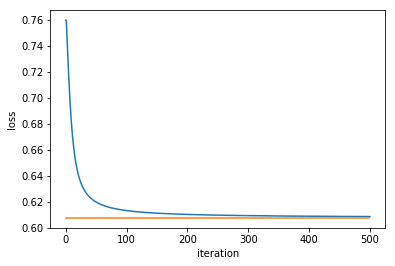

In [7]:
plt.plot(loss_array_true_grad)
plt.plot(optimal_loss.numpy() * np.ones(n_steps), '')

plt.xlabel('iteration')
plt.ylabel('loss')

In [8]:
print('phi_final: ', phi_array_true_grad[-1, :])
print('x_final: ', softmax(torch.from_numpy(phi_array_true_grad[-1, :])).numpy())
print('x_optimal: ', x_optimal.numpy())

phi_final:  [-2.66139054  3.00794148]
x_final:  [0.00343831 0.99656169]
x_optimal:  [0. 1.]


# Train with reinforce gradient

In [9]:
lr = 1e-4 # Note the decayed learning rate
n_steps = 20
loss_array_reinforce, phi_array_reinforce = \
    arm_lib.train_with_reinforce_grad(phi0, p0, lr = lr, n_steps = n_steps)

Text(0,0.5,'loss')

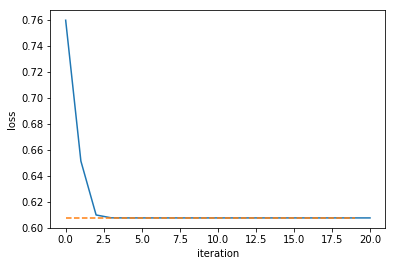

In [10]:
plt.plot(loss_array_reinforce)
plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')

plt.xlabel('iteration')
plt.ylabel('loss')

In [11]:
print('phi_final: ', phi_array_reinforce[-1, :])
print('x_final: ', softmax(torch.from_numpy(phi_array_reinforce[-1, :])).numpy())
print('x_optimal: ', x_optimal.numpy())

phi_final:  [-11.04973888  11.39629078]
x_final:  [1.78571923e-10 1.00000000e+00]
x_optimal:  [0. 1.]


In [12]:
# success of reinforce estimator depends on initial phi0

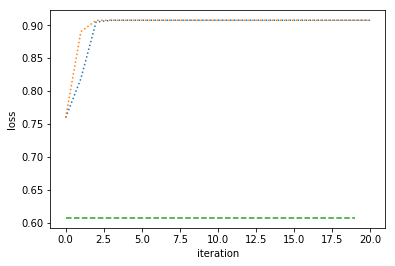

In [17]:
for i in range(2): 
    lr = 1e-4 # Note the decayed learning rate
    n_steps = 20
    loss_array_reinforce, phi_array_reinforce = \
        arm_lib.train_with_reinforce_grad(phi0, p0, lr = lr, n_steps = n_steps)

    plt.plot(loss_array_reinforce, ':')

plt.xlabel('iteration')
plt.ylabel('loss')

plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')


In [18]:
print('phi_final: ', phi_array_reinforce[-1, :])
print('x_final: ', softmax(torch.from_numpy(phi_array_reinforce[-1, :])).numpy())
print('x_optimal: ', x_optimal.numpy())

phi_final:  [ 11.67980671 -11.33325481]
x_final:  [1.00000000e+00 1.01287154e-10]
x_optimal:  [0. 1.]
